# Copyright 2020 Google LLC.
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at

 https://www.apache.org/licenses/LICENSE-2.0

 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32')

print("Ran the import statements.")

Ran the import statements.


In [2]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set

When creating a model with multiple features, the values of each feature should cover roughly the same range. For example, if one feature's range spans 500 to 100,000 and another feature's range spans 2 to 12, then the model will be difficult or impossible to train. Therefore, you should normalize features in a multi-feature model.

The following code cell normalizes datasets by converting each raw value (including the label) to its Z-score. A Z-score is the number of standard deviations from the mean for a particular raw value.

In [3]:
# Calculate the Z-scores of each column in the training set and
# write those Z-scores into a new pandas DataFrame named train_df_norm.
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Examine some of the values of the normalized training set. Notice that most 
# Z-scores fall between -2 and +2.
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
9369,0.2,-0.7,0.5,0.7,0.5,1.6,0.5,0.2,-0.2
7183,0.6,-0.7,-0.4,-0.3,-0.3,-0.6,-0.3,1.1,2.5
13108,-1.2,0.8,1.6,-0.4,-0.4,-0.2,-0.3,-0.2,-0.1
1329,1.2,-1.3,0.7,-1.0,-1.1,-1.1,-1.1,-0.4,-0.4
11348,-0.8,1.4,-0.0,0.1,-0.2,-0.0,-0.1,0.2,-0.7


In [5]:
# Calculate the Z-scores of each column in the test set and
# write those Z-scores into a new pandas DataFrame named test_df_norm.
test_df_mean = test_df.mean()
test_df_std  = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

In classification problems, the label for every example must be either 0 or 1. Unfortunately, the natural label in the California Housing Dataset, median_house_value, contains floating-point values like 80,100 or 85,700 rather than 0s and 1s, while the normalized version of median_house_values contains floating-point values primarily between -3 and +3.

Your task is to create a new column named median_house_value_is_high in both the training set and the test set . If the median_house_value is higher than a certain arbitrary value (defined by threshold), then set median_house_value_is_high to 1. Otherwise, set median_house_value_is_high to 0.

In [6]:
# We arbitrarily set the threshold to 265,000, which is 
# the 75th percentile for median house values.  Every neighborhood
# with a median house price above 265,000 will be labeled 1, 
# and all other neighborhoods will be labeled 0.

# threshold = 265000
# train_df_norm["median_house_value_is_high"] = (train_df["median_house_value"] > threshold).astype(float)
# test_df_norm["median_house_value_is_high"] = (test_df["median_house_value"] > threshold).astype(float) 
# train_df_norm["median_house_value_is_high"].head(8000)


# Alternatively, instead of picking the threshold
# based on raw house values, you can work with Z-scores.
# For example, the following possible solution uses a Z-score
# of +1.0 as the threshold, meaning that no more
# than 16% of the values in median_house_value_is_high
# will be labeled 1.

threshold_in_Z = 1.0 
train_df_norm["median_house_value_is_high"] = (train_df_norm["median_house_value"] > threshold_in_Z).astype(float)
test_df_norm["median_house_value_is_high"] = (test_df_norm["median_house_value"] > threshold_in_Z).astype(float)
train_df_norm["median_house_value_is_high"].head(8000)

9369    0.0
7183    1.0
13108   0.0
1329    0.0
11348   0.0
         ..
2597    0.0
16189   0.0
4578    0.0
13571   0.0
11019   0.0
Name: median_house_value_is_high, Length: 8000, dtype: float64

This code cell specifies the features that you'll ultimately train the model on and how each of those features will be represented. The transformations (collected in feature_layer) don't actually get applied until you pass a DataFrame to it, which will happen when we train the model.

In [7]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# Create a numerical feature column to represent median_income.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Create a numerical feature column to represent total_rooms.
tr = tf.feature_column.numeric_column("total_rooms")
feature_columns.append(tr)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_layer = layers.DenseFeatures(feature_columns)

# Print the first 3 and last 3 rows of the feature_layer's output when applied
# to train_df_norm:
feature_layer(dict(train_df_norm))

<tf.Tensor: shape=(17000, 2), dtype=float32, numpy=
array([[ 0.19637902,  0.748796  ],
       [ 1.127592  , -0.3438911 ],
       [-0.1600907 , -0.42003974],
       ...,
       [-0.37569144,  0.42401746],
       [-0.11680284, -0.84757304],
       [-0.397545  , -0.59343845]], dtype=float32)>

In [16]:
def create_model(my_learning_rate, feature_layer, my_metrics):
    """Create and compile a simple classification model."""
    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()

    # Add the feature layer (the list of features and how they are represented)
    # to the model.
    model.add(feature_layer)

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.  Notice that we're using a different loss
    # function for classification than for regression.    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

    return model        


def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""

    # The x parameter of tf.keras.Model.fit can be a list of arrays, where
    # each array contains the data for one feature.  Here, we're passing
    # every column in the dataset. Note that the feature_layer will filter
    # away most of those columns, leaving only the desired columns and their
    # representations as features.
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name)) 
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # Isolate the classification metric for each epoch.
    hist = pd.DataFrame(history.history)

    return epochs, hist  

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


In [17]:
def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of one or more classification metrics vs. epoch."""  
    # list_of_metrics should be one of the names shown in:
    # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 0s 459us/step - loss: 0.7127 - accuracy: 0.1704
Epoch 2/20
170/170 [==============================] - 0s 498us/step - loss: 0.6175 - accuracy: 0.1726
Epoch 3/20
170/170 [==============================] - 0s 449us/step - loss: 0.5429 - accuracy: 0.2793
Epoch 4/20
170/170 [==============================] - 0s 523us/step - loss: 0.4848 - accuracy: 0.6449
Epoch 5/20
170/170 [==============================] - 0s 444us/step - loss: 0.4389 - accuracy: 0.7641
Epoch 6/20
170/170 [==============================] - 0s 463us/step - loss: 0.4031 - accuracy: 0.8061
Epoch 7/20
170/170 [==============================] - 0s 441us/step - loss: 0.3758 - accuracy: 0.8276
Epoch 8/20
170/170 [==============================] - 0s 500us/step - loss: 0.3554 - accuracy: 0.8429
Epoch 9/20
170/170 [==============================] - 0s 461us/step - loss

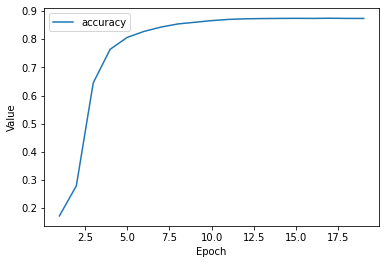

In [18]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.35

# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
          ]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)

In [19]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 471us/step - loss: 0.3131 - accuracy: 0.8680


[0.31309449672698975, 0.8679999709129333]

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 0s 531us/step - loss: 0.5919 - accuracy: 0.5059 - precision: 0.2391 - recall: 0.9276
Epoch 2/20
170/170 [==============================] - 0s 533us/step - loss: 0.5350 - accuracy: 0.5594 - precision: 0.2573 - recall: 0.8999
Epoch 3/20
170/170 [==============================] - 0s 514us/step - loss: 0.4868 - accuracy: 0.6178 - precision: 0.2822 - recall: 0.8682
Epoch 4/20
170/170 [==============================] - 0s 547us/step - loss: 0.4469 - accuracy: 0.6771 - precision: 0.3138 - recall: 0.8236
Epoch 5/20
170/170 [==============================] - 0s 557us/step - loss: 0.4146 - accuracy: 0.7288 - precision: 0.3506 - recall: 0.7749
Epoch 6/20
170/170 [==============================] - 0s 543us/step - loss: 0.3884 - accuracy: 0.7705 - precision: 0.3913 - recall: 0.7292
Epoch 7/20
170/170 [==============================] - 0s

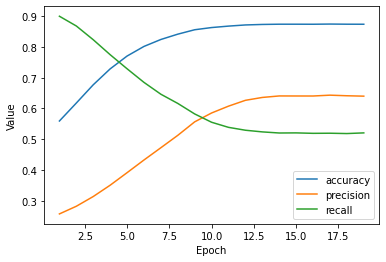

In [20]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.35
label_name = "median_house_value_is_high"

# Here is the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall"] 
plot_curve(epochs, hist, list_of_metrics_to_plot)


# The new graphs suggest that precision and recall are 
# somewhat in conflict. That is, improvements to one of
# those metrics may hurt the other metric.

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 0s 552us/step - loss: 1.1986 - accuracy: 0.3518 - precision: 0.0543 - recall: 0.1808
Epoch 2/20
170/170 [==============================] - 0s 557us/step - loss: 1.0449 - accuracy: 0.4031 - precision: 0.0479 - recall: 0.1404
Epoch 3/20
170/170 [==============================] - 0s 543us/step - loss: 0.9067 - accuracy: 0.4761 - precision: 0.0390 - recall: 0.0933
Epoch 4/20
170/170 [==============================] - 0s 547us/step - loss: 0.7831 - accuracy: 0.5925 - precision: 0.0324 - recall: 0.0519
Epoch 5/20
170/170 [==============================] - 0s 542us/step - loss: 0.6771 - accuracy: 0.7538 - precision: 0.0313 - recall: 0.0169
Epoch 6/20
170/170 [==============================] - 0s 738us/step - loss: 0.5886 - accuracy: 0.8335 - precision: 0.0781 - recall: 0.0018
Epoch 7/20
170/170 [==============================] - 0s

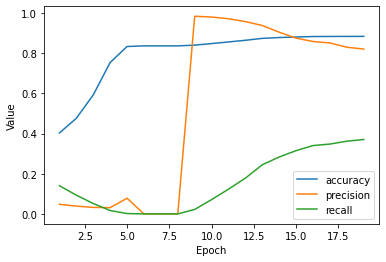

In [21]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.52
label_name = "median_house_value_is_high"

# Here is the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall"] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

# A `classification_threshold` of slightly over 0.5
# appears to produce the highest accuracy (about 83%).
# Raising the `classification_threshold` to 0.9 drops 
# accuracy by about 5%.  Lowering the 
# `classification_threshold` to 0.3 drops accuracy by 
# about 3%. 

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 0s 495us/step - loss: 0.6141 - auc: 0.7856
Epoch 2/20
170/170 [==============================] - 0s 534us/step - loss: 0.5450 - auc: 0.8105
Epoch 3/20
170/170 [==============================] - 0s 554us/step - loss: 0.4908 - auc: 0.8258
Epoch 4/20
170/170 [==============================] - 0s 572us/step - loss: 0.4486 - auc: 0.8337
Epoch 5/20
170/170 [==============================] - 0s 491us/step - loss: 0.4150 - auc: 0.8379
Epoch 6/20
170/170 [==============================] - 0s 495us/step - loss: 0.3885 - auc: 0.8398
Epoch 7/20
170/170 [==============================] - 0s 537us/step - loss: 0.3674 - auc: 0.8392
Epoch 8/20
170/170 [==============================] - 0s 531us/step - loss: 0.3502 - auc: 0.8401
Epoch 9/20
170/170 [==============================] - 0s 553us/step - loss: 0.3376 - auc: 0.8394
Epoch 10/20
170/1

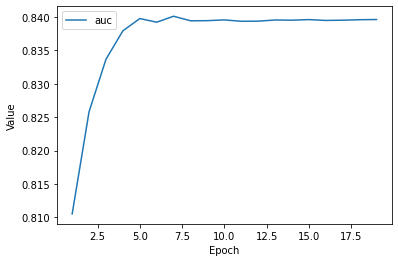

In [22]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"

# AUC is a reasonable "summary" metric for 
# classification models.
# Here is the updated definition of METRICS to 
# measure AUC:
METRICS = [
      tf.keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['auc'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)